# DNN Performance Drop Prediction

**Purpose** Train a DNN-based meta-model to predict a primary model accuracy drop (on various shifted datasets) and beat the baseline.

**Primary Task** RandomForestClassifier to predict low/high sales of video games records. Accuracy on clean validation set 0.798.

**Data for the Performance Drop Regressor**
- training: 500 datasets (X1), their accuracy drop (y), their meta-features (X2)
- validation: take a random split of the previous, if needed.
- test data:
   1. test: 500 datasets (X1) with same shifts as in the training, but different severity (and their X2 and y).
   2. test_unseen: 900 datasets (X1) with other types of shifts, not seen at training time (and their X2 and y).
   3. test_natural: 10 datasets (X1) coming from different domains, but same primary task (and their X2 and y).
   
Each dataset has 475 rows and 9 features (preprocessed already).

Each meta-feature vector contains 114 features (will be preprocessed in this notebook to 110 final features).

**Baseline**

Baseline-Meta-Features: RandomForestRegressor trained on meta features only (prediction_percentiles, PAD, RCA, confidence drop, BBSDs KS and BBSDh X2 statistics, KS statistics on individual preprocessed features.

### Imports

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.experimental.output_all_intermediates(True)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

Here import of what needed to implement DNNs in keras.

In [3]:
import os
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Layer, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model as KerasModel
from tensorflow.random import set_seed as set_random_seed
from tensorflow.keras.optimizers import Adam

### Loading Data and some simple preprocessing

In [4]:
fld = 'data'

In [5]:
with open(os.path.join(fld, 'data.pkl'), 'rb') as f:
    out = pickle.load(f)

In [6]:
train, test, test_unseen, test_natural, ref_task, result_df = out

In [7]:
X_train_1 = train.datasets
y_train = train.drops
train_meta_features_orig = train.meta_features
train_drift_types = train.drift_types

In [8]:
X_test_1 = test.datasets
y_test = test.drops
test_meta_features_orig = test.meta_features
test_drift_types = test.drift_types

In [9]:
X_test_unseen_1 = test_unseen.datasets
y_test_unseen = test_unseen.drops
test_unseen_meta_features_orig = test_unseen.meta_features

In [10]:
X_test_natural_1 = test_natural.datasets
y_test_natural = test_natural.drops
test_natural_meta_features_orig = test_natural.meta_features

In [11]:
test_natural_meta_features_orig.shape

(10, 114)

In [12]:
imp = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('scaler', MinMaxScaler())])

X_train_2 = imp.fit_transform(train_meta_features_orig)
X_test_2 = imp.transform(test_meta_features_orig)
X_test_unseen_2 = imp.transform(test_unseen_meta_features_orig)
X_test_natural_2 = imp.transform(test_natural_meta_features_orig)

In [13]:
X_train_1.shape

(500, 475, 9)

In [14]:
X_train_2.shape

(500, 110)

In [15]:
X_test_1.shape

(500, 475, 9)

In [16]:
X_test_unseen_1.shape

(900, 475, 9)

In [17]:
X_test_natural_1.shape

(10, 475, 9)

Here is the reference task

In [18]:
model = ref_task.model

In [19]:
# source validation dataset
X_src = ref_task.X_orig
y_src = ref_task.y

# reference accuracy
model.score(ref_task.preprocess.transform(X_src), y_src)

0.7978947368421052

You can extract primary predictions for all datasets, and possibly use them as additional features.

In [20]:
X_train_pred = np.array([model.predict_proba(X) for X in X_train_1])
X_train_pred.shape

(500, 475, 2)

In [21]:
X_test_pred = np.array([model.predict_proba(X) for X in X_test_1])
X_test_pred.shape

(500, 475, 2)

In [22]:
X_test_unseen_pred = np.array([model.predict_proba(X) for X in X_test_unseen_1])
X_test_unseen_pred.shape

(900, 475, 2)

In [23]:
X_test_natural_pred = np.array([model.predict_proba(X) for X in X_test_natural_1])
X_test_natural_pred.shape

(10, 475, 2)

### Baseline: Random Forest Regresson on Meta-Features

In [24]:
print("Train Drift Features Baseline Performance Drop Predictor...")

regr = RandomForestRegressor().fit(X_train_2, y_train)

print("Evaluate Drift Features Baseline and save results...")

y_train_drops_pred = regr.predict(X_train_2)

y_test_drops_pred = regr.predict(X_test_2)

y_test_unseen_drops_pred = regr.predict(X_test_unseen_2)

y_test_natural_drops_pred = regr.predict(X_test_natural_2)

Train Drift Features Baseline Performance Drop Predictor...
Evaluate Drift Features Baseline and save results...


In [25]:
mean_absolute_error(y_train, y_train_drops_pred)

0.015347031578947366

In [26]:
mean_absolute_error(y_test, y_test_drops_pred)

0.04576370526315789

In [27]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.06023319298245614

In [28]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05888210526315787

## Training DNNs

DNN based on MLP or LSTM to represent a dataset and predict performance drop.

### Using datasets only, with no meta-features

#### MLP

In [29]:
print("Define MLP-based DNN Performance Drop Predictor...")

# define MLP based model

n_samples_per_dataset = X_train_1.shape[1]
n_features=X_train_1.shape[2]
encoded_ds_size=10
hidden_size=5

input_numeric = Input(shape=(n_samples_per_dataset, n_features), name='dataset')

encoded_data = Dense(units=encoded_ds_size, kernel_initializer='normal', 
                     activation='relu', name='ds_dense')(input_numeric)
encoded_data = GlobalAveragePooling1D()(encoded_data)
encoded_data = Dense(hidden_size, kernel_initializer='normal', 
                     activation='relu', name='ds_avg_dense')(encoded_data)

encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)

drop_predictor = KerasModel(inputs=input_numeric, outputs=performance_drop)

Define MLP-based DNN Performance Drop Predictor...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
print("Train MLP-based DNN Performance Drop Predictor...")

# fit the model

random_state = 42

epochs=300
batch_size=400
validation_split=0.2
verbose=True
early_stop_patience=300
lr=0.001
    
np.random.seed(random_state)
set_random_seed(random_state)

if os.path.exists('./mdc_net.h5'):
            os.remove('./mdc_net.h5')

drop_predictor.compile(loss='mean_absolute_error',
              optimizer=Adam(lr),
              metrics=['mean_absolute_error'])
    
callbacks = [ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', verbose=verbose, 
                             save_best_only=True, mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, 
                           patience=early_stop_patience)]

history = drop_predictor.fit(
    X_train_1, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=verbose
)

drop_predictor = load_model('./mdc_net.h5')

Train MLP-based DNN Performance Drop Predictor...
Train on 400 samples, validate on 100 samples
Epoch 1/300


2021-10-20 15:56:25.069009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


400/400 [==============================] - ETA: 0s - loss: 12.0173 - mean_absolute_error: 12.0173
Epoch 00001: val_loss improved from inf to 4.77347, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 617us/sample - loss: 12.0173 - mean_absolute_error: 12.0173 - val_loss: 4.7735 - val_mean_absolute_error: 4.7735
Epoch 2/300
400/400 [==============================] - ETA: 0s - loss: 11.5896 - mean_absolute_error: 11.5896
Epoch 00002: val_loss improved from 4.77347 to 4.37688, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 75us/sample - loss: 11.5896 - mean_absolute_error: 11.5896 - val_loss: 4.3769 - val_mean_absolute_error: 4.3769
Epoch 3/300
400/400 [==============================] - ETA: 0s - loss: 9.7919 - mean_absolute_error: 9.7919
Epoch 00003: val_loss improved from 4.37688 to 4.00265, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 72us/sample - loss: 9.7919 - mean_absolute_error: 9.7919 - val_loss: 4

/Users/smaggio/workspace/dnn_performance_drop_prediction_under_drift/env_dnn_performance_drop_prediction/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00005: val_loss improved from 3.66796 to 3.36697, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 76us/sample - loss: 7.0042 - mean_absolute_error: 7.0042 - val_loss: 3.3670 - val_mean_absolute_error: 3.3670
Epoch 6/300
400/400 [==============================] - ETA: 0s - loss: 7.2709 - mean_absolute_error: 7.2709
Epoch 00006: val_loss improved from 3.36697 to 3.08046, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 101us/sample - loss: 7.2709 - mean_absolute_error: 7.2709 - val_loss: 3.0805 - val_mean_absolute_error: 3.0805
Epoch 7/300
400/400 [==============================] - ETA: 0s - loss: 7.1247 - mean_absolute_error: 7.1247
Epoch 00007: val_loss improved from 3.08046 to 2.80730, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 191us/sample - loss: 7.1247 - mean_absolute_error: 7.1247 - val_loss: 2.8073 - val_mean_absolute_error: 2.8073
Epoch 8/300
400/400 [==============================] - ETA

Epoch 29/300
400/400 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.0478
Epoch 00029: val_loss did not improve from 0.04250
400/400 [==============================] - 0s 31us/sample - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442
Epoch 30/300
400/400 [==============================] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.0499
Epoch 00030: val_loss did not improve from 0.04250
400/400 [==============================] - 0s 28us/sample - loss: 0.0499 - mean_absolute_error: 0.0499 - val_loss: 0.0436 - val_mean_absolute_error: 0.0436
Epoch 31/300
400/400 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.0483
Epoch 00031: val_loss improved from 0.04250 to 0.04233, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 71us/sample - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 32/300
400/4

Epoch 53/300
400/400 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 00053: val_loss did not improve from 0.04017
400/400 [==============================] - 0s 29us/sample - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 54/300
400/400 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363
Epoch 00054: val_loss did not improve from 0.04017
400/400 [==============================] - 0s 29us/sample - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 55/300
400/400 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 00055: val_loss did not improve from 0.04017
400/400 [==============================] - 0s 34us/sample - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 56/300
400/400 [==============================

400/400 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359
Epoch 00102: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 32us/sample - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 103/300
400/400 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358
Epoch 00103: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 27us/sample - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 104/300
400/400 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358
Epoch 00104: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 27us/sample - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 105/300
400/400 [==============================] - ETA: 0

Epoch 128/300
400/400 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356
Epoch 00128: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 30us/sample - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0413 - val_mean_absolute_error: 0.0413
Epoch 129/300
400/400 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356
Epoch 00129: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 32us/sample - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 130/300
400/400 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357
Epoch 00130: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 35us/sample - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415
Epoch 131/300
400/400 [==========================

Epoch 154/300
400/400 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00154: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 33us/sample - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 155/300
400/400 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355
Epoch 00155: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 30us/sample - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440
Epoch 156/300
400/400 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 00156: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 33us/sample - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440
Epoch 157/300
400/400 [==========================

Epoch 180/300
400/400 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00180: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 28us/sample - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 181/300
400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00181: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 26us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0446 - val_mean_absolute_error: 0.0446
Epoch 182/300
400/400 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 00182: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 25us/sample - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0446 - val_mean_absolute_error: 0.0446
Epoch 183/300
400/400 [==========================

Epoch 206/300
400/400 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350
Epoch 00206: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 31us/sample - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 207/300
400/400 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 00207: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 30us/sample - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 208/300
400/400 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00208: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 32us/sample - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 209/300
400/400 [==========================

Epoch 232/300
400/400 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 00232: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 32us/sample - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 233/300
400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00233: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 34us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0464 - val_mean_absolute_error: 0.0464
Epoch 234/300
400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00234: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 29us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0464 - val_mean_absolute_error: 0.0464
Epoch 235/300
400/400 [==========================

Epoch 258/300
400/400 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 00258: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 28us/sample - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0472 - val_mean_absolute_error: 0.0472
Epoch 259/300
400/400 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373
Epoch 00259: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 27us/sample - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 260/300
400/400 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350
Epoch 00260: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 29us/sample - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 261/300
400/400 [==========================

Epoch 284/300
400/400 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355
Epoch 00284: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 29us/sample - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 285/300
400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00285: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 30us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 286/300
400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00286: val_loss did not improve from 0.03966
400/400 [==============================] - 0s 30us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 287/300
400/400 [==========================

In [31]:
drop_predictor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dataset (InputLayer)         [(None, 475, 9)]          0         
_________________________________________________________________
ds_dense (Dense)             (None, 475, 10)           100       
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
ds_avg_dense (Dense)         (None, 5)                 55        
_________________________________________________________________
perf_drop_dropout (Dropout)  (None, 5)                 0         
_________________________________________________________________
perf_drop (Dense)            (None, 1)                 6         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_______________________________________________________________

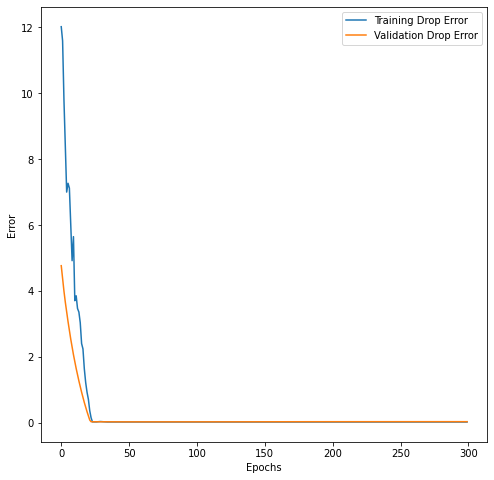

In [32]:
f = plt.figure(figsize=(8, 8))
plt.xlabel("Epochs")
plt.ylabel("Error")

plt.plot(history.history['mean_absolute_error'], label="Training Drop Error")
plt.plot(history.history['val_mean_absolute_error'], label="Validation Drop Error")
plt.legend()

In [33]:
print("Evaluate MLP-based DNN and save results...")

y_train_drops_pred = drop_predictor.predict(X_train_1)

y_test_drops_pred = drop_predictor.predict(X_test_1)

y_test_unseen_drops_pred = drop_predictor.predict(X_test_unseen_1)

y_test_natural_drops_pred = drop_predictor.predict(X_test_natural_1)

Evaluate MLP-based DNN and save results...


In [34]:
mean_absolute_error(y_train, y_train_drops_pred)

0.036598700372913955

In [35]:
mean_absolute_error(y_test, y_test_drops_pred)

0.024681114791380736

In [36]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.049063117394173704

In [37]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05585996493344244

#### LSTM

In [38]:
print("Define LSTM-based DNN Performance Drop Predictor...")

# define LSTM based model

n_samples_per_dataset = X_train_1.shape[1]
n_features=X_train_1.shape[2]
encoded_ds_size=10
hidden_size=5

input_shape = (n_samples_per_dataset, n_features)
input_numeric = Input(shape=input_shape, name='dataset')

encoded_data = Bidirectional(LSTM(units=encoded_ds_size, return_sequences=False,
                             input_shape=input_shape), name='encoded_dataset')(input_numeric)

encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)

drop_predictor = KerasModel(inputs=input_numeric, outputs=performance_drop)

Define LSTM-based DNN Performance Drop Predictor...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
print("Train LSTM-based DNN Performance Drop Predictor...")

# fit the model

random_state = 42

epochs=300
batch_size=400
validation_split=0.2
verbose=True
early_stop_patience=300
lr=0.001
    
np.random.seed(random_state)
set_random_seed(random_state)

if os.path.exists('./mdc_net.h5'):
    os.remove('./mdc_net.h5')
        
drop_predictor.compile(loss='mean_absolute_error',
              optimizer=Adam(lr),
              metrics=['mean_absolute_error'])
    
callbacks = [ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', verbose=verbose, 
                             save_best_only=True, mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, 
                           patience=early_stop_patience)]

history = drop_predictor.fit(
    X_train_1, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=verbose
)

drop_predictor = load_model('./mdc_net.h5')

Train LSTM-based DNN Performance Drop Predictor...
Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - ETA: 0s - loss: 0.1078 - mean_absolute_error: 0.1078
Epoch 00001: val_loss improved from inf to 0.10080, saving model to ./mdc_net.h5


/Users/smaggio/workspace/dnn_performance_drop_prediction_under_drift/env_dnn_performance_drop_prediction/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


400/400 [==============================] - 1s 2ms/sample - loss: 0.1078 - mean_absolute_error: 0.1078 - val_loss: 0.1008 - val_mean_absolute_error: 0.1008
Epoch 2/300
400/400 [==============================] - ETA: 0s - loss: 0.1036 - mean_absolute_error: 0.1036
Epoch 00002: val_loss improved from 0.10080 to 0.09627, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 651us/sample - loss: 0.1036 - mean_absolute_error: 0.1036 - val_loss: 0.0963 - val_mean_absolute_error: 0.0963
Epoch 3/300
400/400 [==============================] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.0993
Epoch 00003: val_loss improved from 0.09627 to 0.09202, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 627us/sample - loss: 0.0993 - mean_absolute_error: 0.0993 - val_loss: 0.0920 - val_mean_absolute_error: 0.0920
Epoch 4/300
400/400 [==============================] - ETA: 0s - loss: 0.0979 - mean_absolute_error: 0.0979
Epoch 00004: val_loss improved from 0

Epoch 25/300
400/400 [==============================] - ETA: 0s - loss: 0.0501 - mean_absolute_error: 0.0501
Epoch 00025: val_loss improved from 0.04906 to 0.04868, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 688us/sample - loss: 0.0501 - mean_absolute_error: 0.0501 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 26/300
400/400 [==============================] - ETA: 0s - loss: 0.0521 - mean_absolute_error: 0.0521
Epoch 00026: val_loss improved from 0.04868 to 0.04831, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 706us/sample - loss: 0.0521 - mean_absolute_error: 0.0521 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 27/300
400/400 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487
Epoch 00027: val_loss improved from 0.04831 to 0.04796, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 679us/sample - loss: 0.0487 - mean_absolute_error: 0.0487 

Epoch 49/300
400/400 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413
Epoch 00049: val_loss improved from 0.04283 to 0.04246, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 767us/sample - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0425 - val_mean_absolute_error: 0.0425
Epoch 50/300
400/400 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 00050: val_loss improved from 0.04246 to 0.04208, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 699us/sample - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421
Epoch 51/300
400/400 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 00051: val_loss improved from 0.04208 to 0.04191, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 720us/sample - loss: 0.0398 - mean_absolute_error: 0.0398 

Epoch 74/300
400/400 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357
Epoch 00074: val_loss improved from 0.04147 to 0.04146, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 709us/sample - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415
Epoch 75/300
400/400 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364
Epoch 00075: val_loss improved from 0.04146 to 0.04143, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 695us/sample - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 76/300
400/400 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 00076: val_loss improved from 0.04143 to 0.04140, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 692us/sample - loss: 0.0362 - mean_absolute_error: 0.0362 

Epoch 98/300
400/400 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341
Epoch 00098: val_loss improved from 0.04002 to 0.03995, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 653us/sample - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0400 - val_mean_absolute_error: 0.0400
Epoch 99/300
400/400 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328
Epoch 00099: val_loss improved from 0.03995 to 0.03986, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 665us/sample - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399
Epoch 100/300
400/400 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341
Epoch 00100: val_loss improved from 0.03986 to 0.03978, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 691us/sample - loss: 0.0341 - mean_absolute_error: 0.0341

Epoch 145/300
400/400 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309
Epoch 00145: val_loss improved from 0.03751 to 0.03747, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 931us/sample - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 146/300
400/400 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325
Epoch 00146: val_loss improved from 0.03747 to 0.03743, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 709us/sample - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 147/300
400/400 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0306
Epoch 00147: val_loss improved from 0.03743 to 0.03741, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 713us/sample - loss: 0.0306 - mean_absolute_error: 0.03

400/400 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296
Epoch 00170: val_loss did not improve from 0.03739
400/400 [==============================] - 0s 710us/sample - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 171/300
400/400 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309
Epoch 00171: val_loss did not improve from 0.03739
400/400 [==============================] - 0s 726us/sample - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 172/300
400/400 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0305
Epoch 00172: val_loss did not improve from 0.03739
400/400 [==============================] - 0s 708us/sample - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 173/300
400/400 [==============================] - ETA

Epoch 221/300
400/400 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.0293
Epoch 00221: val_loss did not improve from 0.03726
400/400 [==============================] - 0s 782us/sample - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 222/300
400/400 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 00222: val_loss did not improve from 0.03726
400/400 [==============================] - 0s 841us/sample - loss: 0.0294 - mean_absolute_error: 0.0294 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 223/300
400/400 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.0287
Epoch 00223: val_loss did not improve from 0.03726
400/400 [==============================] - 0s 751us/sample - loss: 0.0287 - mean_absolute_error: 0.0287 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 224/300
400/400 [=======================

Epoch 247/300
400/400 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300
Epoch 00247: val_loss improved from 0.03719 to 0.03715, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 760us/sample - loss: 0.0300 - mean_absolute_error: 0.0300 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 248/300
400/400 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303
Epoch 00248: val_loss improved from 0.03715 to 0.03711, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 755us/sample - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 249/300
400/400 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 00249: val_loss improved from 0.03711 to 0.03709, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 752us/sample - loss: 0.0295 - mean_absolute_error: 0.02

Epoch 272/300
400/400 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.0297
Epoch 00272: val_loss did not improve from 0.03695
400/400 [==============================] - 0s 819us/sample - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 273/300
400/400 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 00273: val_loss did not improve from 0.03695
400/400 [==============================] - 0s 717us/sample - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 274/300
400/400 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 00274: val_loss did not improve from 0.03695
400/400 [==============================] - 0s 699us/sample - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 275/300
400/400 [=======================

Epoch 298/300
400/400 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 00298: val_loss improved from 0.03682 to 0.03677, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 861us/sample - loss: 0.0281 - mean_absolute_error: 0.0281 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 299/300
400/400 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 00299: val_loss improved from 0.03677 to 0.03673, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 792us/sample - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 300/300
400/400 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.0291
Epoch 00300: val_loss improved from 0.03673 to 0.03669, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 823us/sample - loss: 0.0291 - mean_absolute_error: 0.02

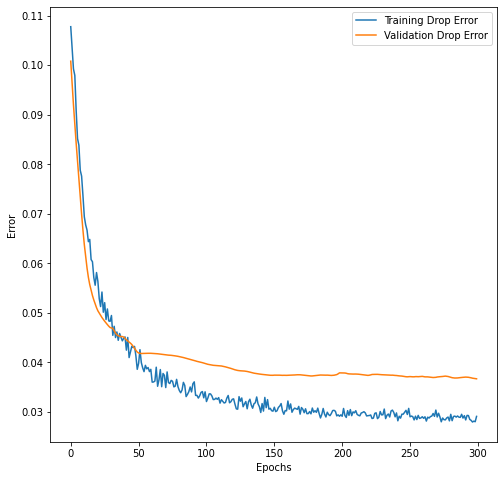

In [40]:
f = plt.figure(figsize=(8, 8))
plt.xlabel("Epochs")
plt.ylabel("Error")

plt.plot(history.history['mean_absolute_error'], label="Training Drop Error")
plt.plot(history.history['val_mean_absolute_error'], label="Validation Drop Error")
plt.legend()

In [41]:
print("Evaluate LSTM-based DNN and save results...")

y_train_drops_pred = drop_predictor.predict(X_train_1)

y_test_drops_pred = drop_predictor.predict(X_test_1)

y_test_unseen_drops_pred = drop_predictor.predict(X_test_unseen_1)

y_test_natural_drops_pred = drop_predictor.predict(X_test_natural_1)

Evaluate LSTM-based DNN and save results...


In [42]:
mean_absolute_error(y_train, y_train_drops_pred)

0.028964305240100154

In [43]:
mean_absolute_error(y_test, y_test_drops_pred)

0.022716608752984757

In [44]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.052004002735010005

In [45]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.06264404282091479